# 인공신경망 모델의 학습

## 학습데이터 불러오기

In [13]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [26]:
config_info = {
    'data_folder': './',
    'data_folder_raw': 'E:/',
    'result_file': 'result.csv',
}

In [27]:
def format_data_x(datafile):
    x_data = None
    for item in datafile:
        item_data = np.loadtxt(item, dtype=np.float)
        if x_data is None:
            x_data = np.zeros((len(item_data), 1))
        x_data = np.hstack((x_data, item_data))
    x_data = x_data[:, 1:]
    X = None
    for i in range(len(x_data)):
        row = np.asarray(x_data[i, :])
        row = row.reshape(9, 128).T
        if X is None:
            X = np.zeros((len(x_data), 128, 9))
        X[i] = row
    return X

In [28]:
# This is for parsing the Y data, you can ignore it if you do not need preprocessing
def format_data_y(datafile):
    data = np.loadtxt(datafile, dtype=np.int) - 1
    YY = np.eye(6)[data]
    return YY

In [29]:
# Load data function, if there exists parsed data file, then use it
# If not, parse the original dataset from scratch
def load_data():
    import os
    if os.path.isfile(config_info['data_folder'] + 'data_har.npz') == True:
        data = np.load(config_info['data_folder'] + 'data_har.npz')
        X_train = data['X_train']
        Y_train = data['Y_train']
        X_test = data['X_test']
        Y_test = data['Y_test']
        print(X_train.shape)
        print(X_test.shape)
        print(Y_train.shape)
        print(Y_test.shape)
        
    else:
        # This for processing the dataset from scratch
        # After downloading the dataset, put it to somewhere that str_folder can find
        str_folder = config_info['data_folder_raw'] + 'UCI HAR Dataset/'
        INPUT_SIGNAL_TYPES = [
            "body_acc_x_",
            "body_acc_y_",
            "body_acc_z_",
            "body_gyro_x_",
            "body_gyro_y_",
            "body_gyro_z_",
            "total_acc_x_",
            "total_acc_y_",
            "total_acc_z_"
        ]
        print(str_folder)
        str_train_files = [str_folder + 'train/' + 'Inertial Signals/' + item + 'train.txt' for item in
                           INPUT_SIGNAL_TYPES]
        str_test_files = [str_folder + 'test/' + 'Inertial Signals/' +
                          item + 'test.txt' for item in INPUT_SIGNAL_TYPES]
        str_train_y = str_folder + 'train/y_train.txt'
        str_test_y = str_folder + 'test/y_test.txt'

        X_train = format_data_x(str_train_files)
        X_test = format_data_x(str_test_files)
        Y_train = format_data_y(str_train_y)
        Y_test = format_data_y(str_test_y)
        print(X_train.shape)
        print(X_test.shape)
        print(Y_train.shape)
        print(Y_test.shape)
        
    # npz파일 생성용 !주의 없을때 한번만 실행기키고 바로 주석처리
    #return X_train, Y_train, X_test, Y_test
    return X_train, onehot_to_label(Y_train), X_test, onehot_to_label(Y_test)

In [30]:
def onehot_to_label(y_onehot):
    a = np.argwhere(y_onehot == 1)
    return a[:, -1]

In [31]:
class data_loader(Dataset):
    def __init__(self, samples, labels, t):
        self.samples = samples
        self.labels = labels
        self.T = t

    def __getitem__(self, index):
        sample, target = self.samples[index], self.labels[index]
        if self.T:
            return self.T(sample), target
        else:
            return sample, target

    def __len__(self):
        return len(self.samples)

In [32]:
def load(batch_size=64):
    x_train, y_train, x_test, y_test = load_data()
    # npz파일 생성용 !주의 없을때 한번만 실행기키고 바로 주석처리
    #np.savez('E:/연구실/04.신생아 동작인식/data_har.npz', X_train=x_train, Y_train=y_train, X_test=x_test, Y_test=y_test)
    x_train, x_test = x_train.reshape(
        (-1, 9, 1, 128)), x_test.reshape((-1, 9, 1, 128))
    
    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    transform = None
    train_set = data_loader(x_train, y_train, transform)
    test_set = data_loader(x_test, y_test, transform)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

## 필요한 라이브러리 불러오기

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.optim import lr_scheduler

## 모델, 손실 함수, 최적화 함수 설정

In [56]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=9, out_channels=32, kernel_size=(1, 9)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 9)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * 26, out_features=1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=1000, out_features=500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=500, out_features=6)
        )
                
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(-1, 64 * 26)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = F.softmax(out, dim=1)
        return out

## 하이퍼파라미터

In [57]:
epoch = 200
batch_size = 919
lr = 0.001

momemtum =0.9

In [58]:
train_loader, test_loader = load(batch_size=batch_size)

(7352, 128, 9)
(2947, 128, 9)
(7352, 6)
(2947, 6)
(7352, 9, 1, 128)
(2947, 9, 1, 128)
(7352,)
(2947,)


In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)

loss_func = nn.CrossEntropyLoss()

#optimizer = optim.SGD(params=model.parameters(), lr=lr, momentum=momemtum)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, threshold=1, patience=1, mode='min')

cuda:0


## 모델의 학습

1. lr과 scheduler를 이용해서 빠르게 학습 시켜나갈수 있다. 
학습에는 속도차이뿐 lr이 엄청 큰 숫자만 아니면 문제x 그러나 scheduler가 숫자를 낮추는데도 에폭이 필요하니까. lr은 적당히 크게
2. 배치사이즈는 클수록 좋지만 너무 커지면, 수용성이 높아져서 테스트셋결과가 좋지않음
3. 배치정규화는학습을 빨리시키게해줌. 수용성을 강화, 즉 오버피티잉 일어나게할가능성이 있음. 학습을 조금해야할때 유리. 이것만 쓰면 성능이 되려 떨어짐
4. 드랍아웃은 학습을 느리게 만들어서,  수용성을 약화시키고, 오버피팅이 덜일어나게함 -> 성능에 영향 미침/ 안쓰면 트레인셋에만 적합하게 학습됨! 꼭써야함!
5. 에폭은 적으면 좋지만, 학습량이 부족하다고 판단시(loss선이 일직선으로 안나타나면)  에폭 추가
6. 오버피팅이 천천히 일어난다는 의미는 그만큼 에폭수를 늘려도 성장할수 있는 가능성을 나타냄
7. 반대로 학습이 다 되었을때는 lr의 값에 상관없이 비슷한 성능을 내게됨. 즉
lr은 scheuler만 있다면 큰 의미 없음.
8. 초기값이 미치는 영향 -> 학습을 조금빠르게할수있는 가능성뿐 성능에 영향을 미치지는 않음.
9. 배치정규화와 드랍아웃을 같이 사용한다면 학습을 빠르게 하는게 가능하면서, 성능이 올라감/ 
10. 드랍아웃의 비율을 높이면 트레인셋이 덜 높게 학습되지만, 테스트셋에대하 성능이 올라감. (배치정규화의힘/비율을 높여도 학습이 잘됨)
11.  모델의 사이즈(웨이트 양을)줄여본다면(수용성을 적게만들면), 좀더 완만한 선을 그리게하면-> 구분해야할 결과가 적다면, 그렇게 깊고 큰 뉴럴넷이 좋은건 아니라고 알고있는데, fc건드는수준으로는 유의미한 결과가 나타나지않음
12. 배치정규화와 드랍아웃 동시 적용 + 드랍아웃 비율 높임 0.4이정도가 가장 좋은 성능을 보여줌

In [70]:
def train_only():
    torch.manual_seed(0)

    loss_array = []
    result_array = []
    n_batch = len(train_loader.dataset) // batch_size

    for i in range(epoch):
        #correct, total_loss = 0, 0
        for j, [image, label] in enumerate(train_loader):
            train_x = image.to(device).float()
            train_y = label.to(device).long()

            optimizer.zero_grad()
            output = model.forward(train_x)

            loss = loss_func(output,train_y)
            loss.backward()
            optimizer.step()

            #total_loss += loss.item()
            #_, predicted = torch.max(output.data, 1)
            #total += label.size(0)
            #correct += (predicted == train_y).sum()
            #acc_train = float(correct) * 100.0 / (batch_size * n_batch)
        #print( 'Epoch: [{}/{}], loss: {:.4f}, train acc: {:.2f}%'.format(i + 1, epoch, total_loss * 1.0 / n_batch,acc_train))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


KeyboardInterrupt: 

In [ ]:
torch.manual_seed(0)

loss_array = []
result_array = []
n_batch = len(train_loader.dataset) // batch_size

for i in range(epoch):
    model.train()
    correct, total_loss = 0, 0
    total = 0
    for j, [image, label] in enumerate(train_loader):
        train_x = image.to(device).float()
        train_y = label.to(device).long()

        optimizer.zero_grad()
        output = model.forward(train_x)

        loss = loss_func(output,train_y)
        loss.backward()
        optimizer.step()
    
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == train_y).sum()
    acc_train = float(correct) * 100.0 / (batch_size * n_batch)
    #print( 'Epoch: [{}/{}], loss: {:.4f}, train acc: {:.2f}%'.format(i + 1, epoch, total_loss * 1.0 / n_batch,acc_train))
    
    #-----------------------------------------------------------------
    # 인퍼런스 모드를 위해 no_grad 해줍니다.
    model.eval()
    model.train(False)
    with torch.no_grad():
        correct, total = 0, 0
        for j, [image, label] in enumerate(test_loader):
            # 두 데이터 모두 장치에 올립니다.
            x = image.to(device).float()
            y_= label.to(device)

            # 모델에 데이터를 넣고 결과값을 얻습니다.
            output = model.forward(x)

            _,predicted = torch.max(output,1)
            # 전체 개수는 라벨의 개수로 더해줍니다.
            # 전체 개수를 알고 있음에도 이렇게 하는 이유는 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기 때문입니다.
            total += y_.size(0)

            # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
            correct += (predicted == y_).sum()#.float()

    # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
    acc_test = float(correct) * 100 / total
    #print("Accuracy of Test Data: {}%".format(float(correct) * 100 / total))
    #print('Epoch: [{}/{}], test acc: {:.2f}%'.format(i + 1, epoch, float(correct) * 100 / total))
    #----------------------------------------------------------------- 
    
    loss_array.append(loss)
    result_array.append([acc_train, acc_test])
    print( 'Epoch: [{}/{}]  loss: {:.4f}  train acc: {:.2f}%  test acc: {:.2f}%'.format(i + 1, epoch, total_loss * 1.0 / n_batch,acc_train,acc_test))


## 모델 테스트  함수

In [177]:
def show_result():
    print(CNN())
    print("\nepoch:{} ".format(epoch),
          "lr:{} ".format(lr),
          "batch:{} ".format(batch_size),
          "train_acc:{0:.2f}% ".format(acc_train),
          "test_acc:{0:.2f}%".format(acc_test))

    plt.rcParams['figure.figsize'] = [10, 5]
    fig, axs = plt.subplots(1,2)
    axs[0].plot(loss_array)
    axs[0].legend(['loss'])
    #axs[0].set(ylim=[0.5, 1.5], xlabel='epoch')
    axs[1].plot(result_array)
    axs[1].legend(['train_acc','test_acc'])
    #axs[1].set(ylim=[80, 100], xlabel='epoch')
    plt.show()

# 기록

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05

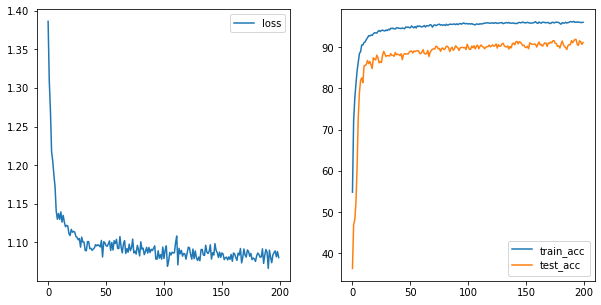

In [195]:
show_result()

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=500, out_features=6, bias=True)
  )
)

epoch:100  lr:0.01  batch:919  train_acc:39.05%  test_acc:38.89%


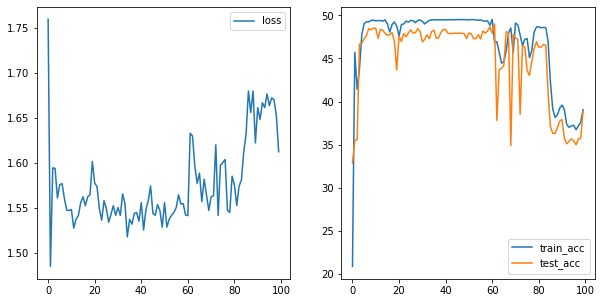

In [35]:
show_result()

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=500, out_features=6, bias=True)
  )
)

epoch:100  lr:0.0005  batch:919  train_acc:94.61%  test_acc:85.48%


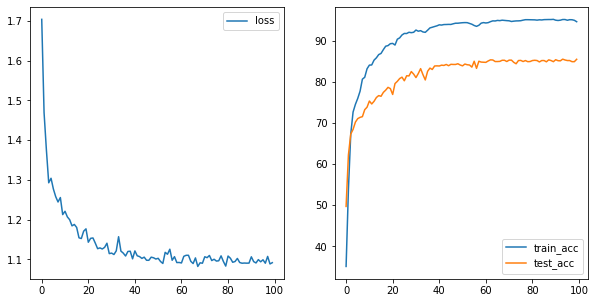

In [42]:
show_result()

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=500, out_features=6, bias=True)
  )
)

epoch:100  lr:0.0005  batch:919  train_acc:96.01%  test_acc:88.26%


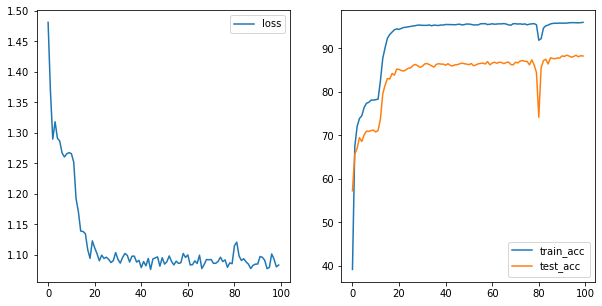

In [49]:
show_result()

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=500, out_features=6, bias=True)
  )
)

epoch:1000  lr:0.0005  batch:919  train_acc:98.38%  test_acc:88.06%


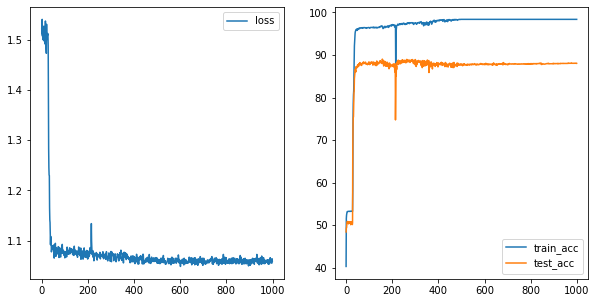

In [77]:
show_result()

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_featur

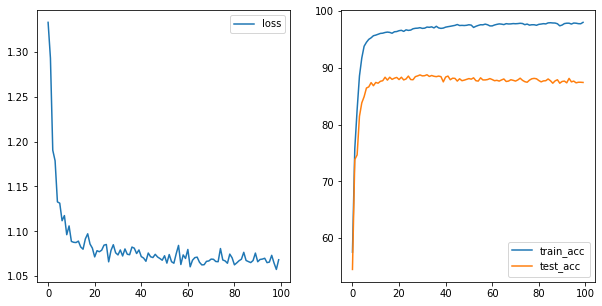

배치정규화


In [62]:
show_result()
print("배치정규화")

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_featur

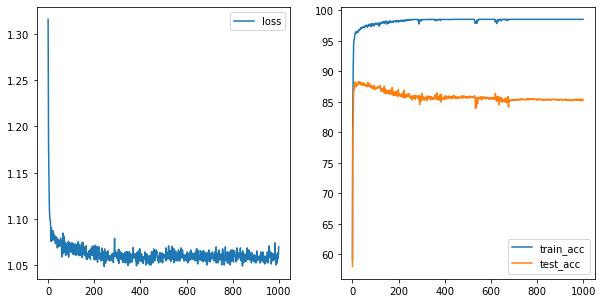

배치정규화


In [67]:
show_result()
print("배치정규화")

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=500, out_features=6, bias=True)
  )
)

epoch:1000  lr:0.0005  batch:1838  train_acc:98.31%  test_acc:85.99%


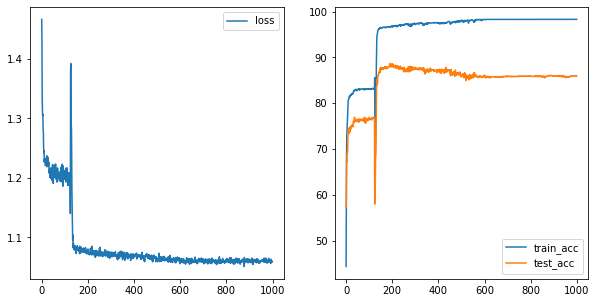

In [83]:
show_result()

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=500, out_features=6, bias=True)
  )
)

epoch:1000  lr:0.0005  batch:919  train_acc:97.95%  test_acc:90.36%


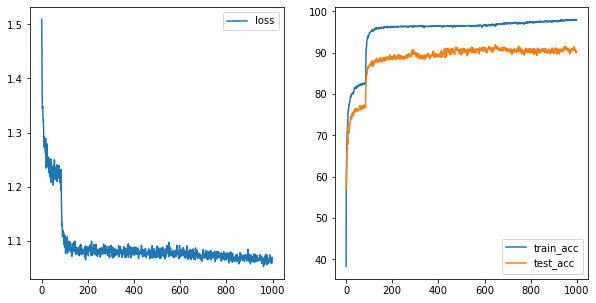

In [22]:
show_result()

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=500, out_features=6, bias=True)
  )
)

epoch:100  lr:0.001  batch:919  train_acc:95.73%  test_acc:89.14%


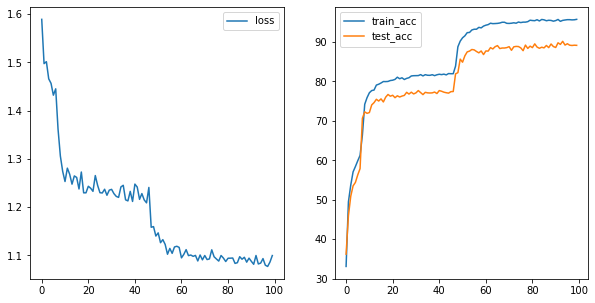

In [32]:
show_result()

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=500, out_features=6, bias=True)
  )
)

epoch:100  lr:0.0015  batch:919  train_acc:95.80%  test_acc:90.53%


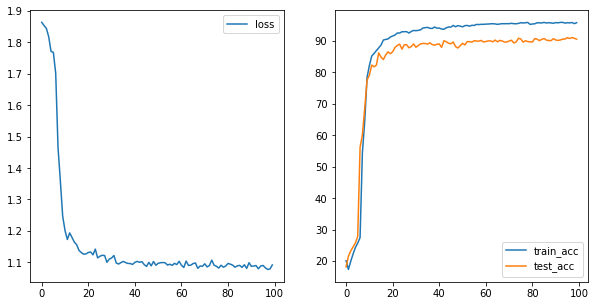

In [41]:
show_result()

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.25, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.25, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=500, out_features=6, bias=True)
  )
)

epoch:100  lr:0.0015  batch:919  train_acc:94.82%  test_acc:90.13%


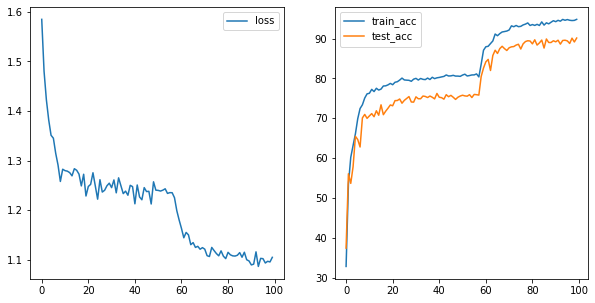

In [72]:
show_result()

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.25, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.25, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=500, out_features=6, bias=True)
  )
)

epoch:200  lr:0.001  batch:919  train_acc:95.57%  test_acc:90.16%


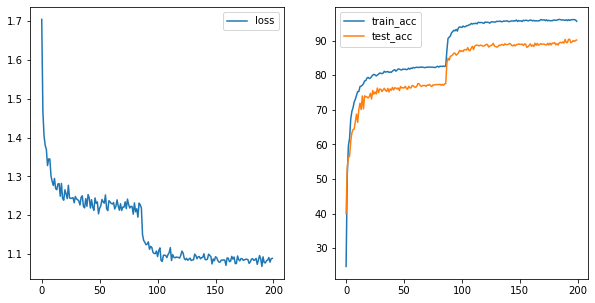

In [85]:
print("드랍아웃  적용/  비율 높임 2.5")
show_result()

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=500, out_features=6, bias=True)
  )
)

epoch:200  lr:0.001  batch:919  train_acc:96.11%  test_acc:90.33%


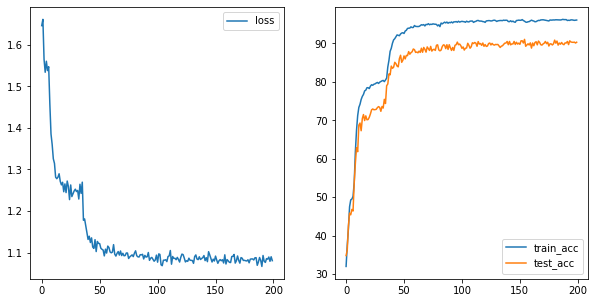

In [91]:
print("학습률 조정")
show_result()

CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=500, out_features=6, bias=True)
  )
)

epoch:200  lr:0.0015  batch:919  train_acc:95.78%  test_acc:89.41%


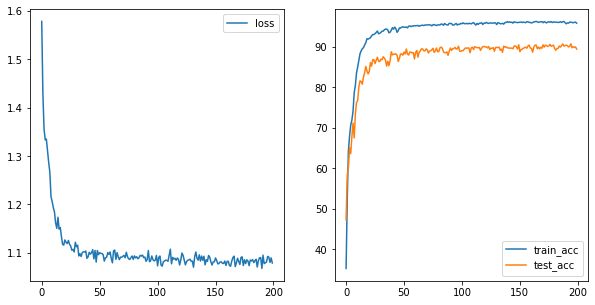

In [103]:
print("드랍아웃 만 사용")
show_result()

배치정규화와 드랍아웃 동시 적용
CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): BatchNor

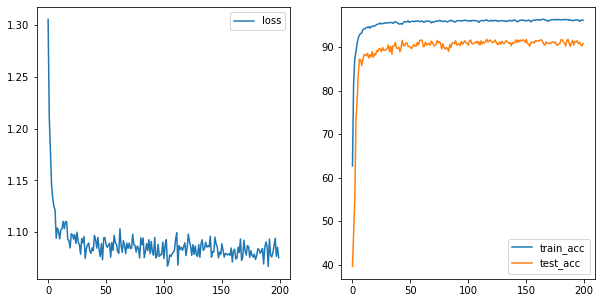

In [109]:
print("배치정규화와 드랍아웃 동시 적용")
show_result()

배치정규화와 드랍아웃 동시 적용 + 드랍아웃 비율 높임
CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.25, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.25, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
 

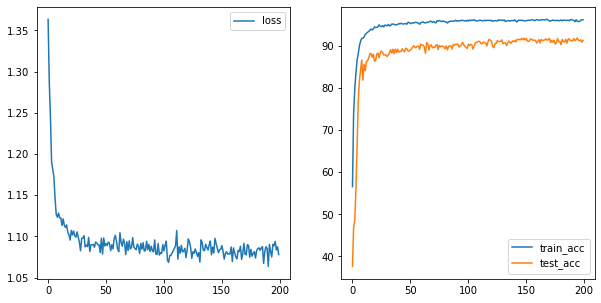

In [126]:
print("배치정규화와 드랍아웃 동시 적용 + 드랍아웃 비율 높임")
show_result()

배치정규화와 드랍아웃 동시 적용 + 드랍아웃 비율 높임 0.3
CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)


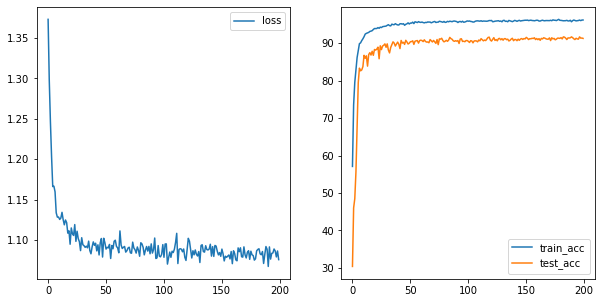

In [132]:
print("배치정규화와 드랍아웃 동시 적용 + 드랍아웃 비율 높임 0.3")
show_result()

배치정규화와 드랍아웃 동시 적용 + 드랍아웃 비율 높임 0.3 + FC 웨이트 줄임
CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=500, out_features=100, bi

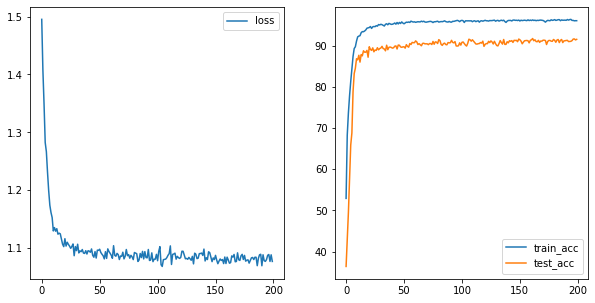

In [144]:
print("배치정규화와 드랍아웃 동시 적용 + 드랍아웃 비율 높임 0.3 + FC 웨이트 줄임")
show_result()

배치정규화와 드랍아웃 동시 적용 + 드랍아웃 비율 높임 0.4
CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.4, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.4, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)


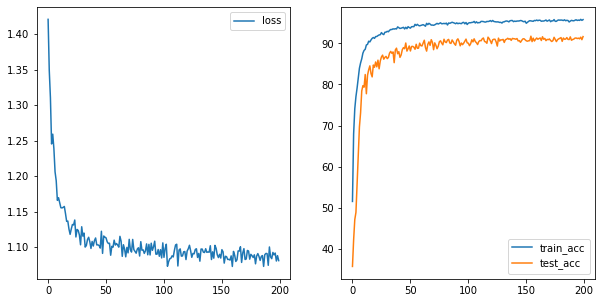

In [150]:
print("배치정규화와 드랍아웃 동시 적용 + 드랍아웃 비율 높임 0.4")
show_result()

배치정규화와 드랍아웃 동시 적용 + 드랍아웃 비율 높임 0.4
CNN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1664, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)


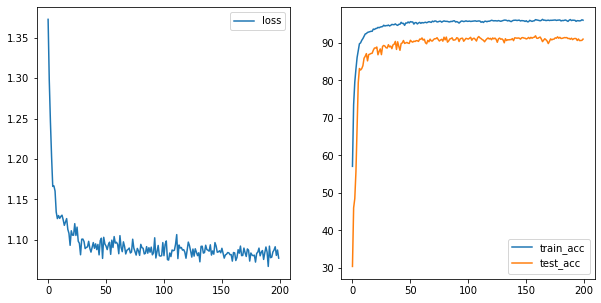

In [184]:
print("배치정규화와 드랍아웃 동시 적용 + 드랍아웃 비율 높임 0.4")
show_result()